In [1]:
#!/usr/bin/python2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat
from datetime import datetime, date, time

In [2]:
# import features (x,y)-coordinate
mat_features = loadmat('')  # load mat-file
df_features = pd.DataFrame({'pos_x' : mat_features['pos_x'][:,1], 'pos_y' : mat_features['pos_y'][:,1]})
df_features.shape

(138517, 2)

In [3]:
df_features.head()

,pos_x,pos_y
0,140.153000,116.778000
1,139.514999,102.313004
2,135.598999,113.057999
3,135.391998,104.260002
4,135.697006,112.859001


In [4]:
# import classes/cluster/segmentation corresponding to each feature
mat_classes = loadmat('')                           
df_classes = pd.DataFrame(mat_classes['classes_library_updated'])
df_classes.shape

(138517, 50)

In [5]:
df_classes.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0,0,28181,28693,0,0,28197,28709,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,25651,26163,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,25637,0,0,0,25141,25653,26165,0,25669,...,0,0,0,0,0,0,0,0,0,0
3,0,23093,0,0,23109,23621,0,0,23125,23637,...,0,0,0,0,0,0,0,0,0,0
4,0,25637,0,0,25653,26165,0,25669,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# df_join = pd.concat([df_features, df_classes], axis=1)
# df_join.head()

The input is the positions of the mobile-service-user (x-y cooridinate), the output is the BEST resource allocation (classes) corresponds to that position. 

However, from first observation, we can see there are more than 1 best solutions at each positions. This causes the confusion in chosing class to the user, given the fact that any of these classes give the same performance (goodput). Thus we design a criteria to choose one of among these classes. This criteria should be in favour fo the learning algorithms, i.e. improve the learnability of the learning systems.

# The unique class.
Here I would like to know how many unique classes, and their frequency

In [7]:
df_classes.replace(0, np.nan, inplace=True)
frequency = pd.value_counts(df_classes.values.flatten(), sort=True)
len(frequency)
# frequency.values
# frequency.index

137

In [8]:
frequency.head()

27173.0    19206
27685.0    18891
26661.0    16448
26677.0    16353
28197.0    15957
dtype: int64

There are 137 unique classes.
The class distribution is shown as followed:

Text(0.5,0,'Classes')

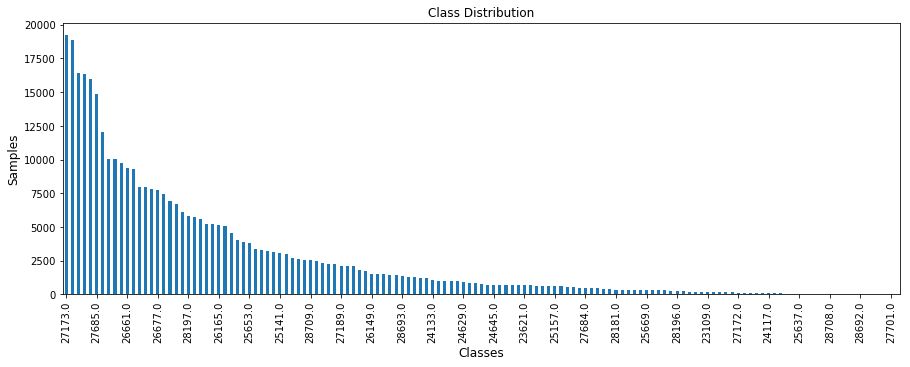

In [9]:
frequency.plot(kind='bar', figsize=(15, 5))
plt.xticks(np.arange(0,136,5), label=frequency.index, rotation='vertical');
plt.title('Class Distribution')
plt.ylabel('Samples', fontsize=12)
plt.xlabel('Classes', fontsize=12)

This dataset features the imbalancing distribution of samples per class. To be specific, class 27173 has over 19000 samples while class 27701 contains merely 2 elements. The training algoirthms have tendency to be biased to the "dominant classes".

In fact, this behavior is pretty much like human, imagine we are giving a multiple choice examination (with 4 choices: A, B, C D) and facing a question we dont know the answer. However, rumor has it that 95% of the correct answer is A, we immediately choose A without thinking much.

Whats more? This dataset even has an issue of overlapping between classes, i.e. Many samples belong to multiple classes. The imbalance and the overlapping together, will affect the accuracy of the training.

Through grouping the samples by their class, we can point out the overlapping between classes shown in the following scatter plots:

<img src="Figures/ScPlotS1.jpg" width="350"/>

Lets try having a closer look to the scatter plot by considering only some overlapping classes as followed:

<table><tr>
<td> <img src="Figures/OverlappingClasses.png"  width= "250px"/> </td>
<td> <img src="Figures/OverlappingClassesS.png" width= "250px"/> </td>
<td> <img src="Figures/OverlappingClassesA.png"  width= "250px"/> </td>
</tr></table>

So there are two type of overlapping here in the dataset:
- The Samples overlapping. Causation: Sample belong to multiple classes
- The Area Overlapping. Causation: Each class occupies a certain region (the outside limit or the edge of the class), these region happen to overlap with each other.

Before implementing any clustering algorithms to remove all the overlapping issues, we need to form __metrics__. This helps telling us how good or bad an algorithm is.
From this observation, we can design __metrics__ to measure the performance of clustering algorithms. In an optimal solution, two type of overlapping should be resolved. Specifically, all samples belong to a single class (__first metric__), and the boundary region of classes dont overlap to each other (__second metric__).

The First metric is called "samples overlapping" formed by taking the sum of samples in each class and divide to total samples:

\begin{align}\label{eq:metric1}
\displaystyle\sum_{i=1}^{|C|} |c_i| > |P|
\end{align}
where $|c_i|$ is number of samples in class $c_i$, $|P|$ is total number of samples (without considering class) in the dataset, i.e, $c_i$ is a subset of $P$: $c_i \subset P$ and $|C|$ is total number of classes.

Second metric is called "areas overlapping" property is defined in the second metric or area ratio metric given by:
\begin{align}\label{eq:metric2}
\displaystyle\sum_{i=1}^{|C|} S_{c_i} > S_{bound} \Longleftrightarrow \frac{\displaystyle\sum_{i=1}^{|C|} S_{c_i}}{\displaystyle S_{bound}} > 1
\end{align}	
where $|S_{c_i}|$ is boundary area of class $c_i$; $|C|$ is total number of classes and $S_{bound}$ is the boundary area of all samples.

A simple explaination for the second metric is as followed:

<img src="Figures/Metric2e.png" width="500"/>

Originally, on the left picture, the black and blue square's areas are overlapped to each other, so $S_{blue} + S_{black} > S_{boundary}$ because of the overlapping area is counted twice. After the clustering algorithm, we obtain the right picture, the overlapping region was treated and shared equally to each square, thus  $S_{blue} + S_{black} = S_{boundary}$